In [13]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

## 1. Dataset

In [14]:
K = 5 # 5가지의 값을 샘플링
mu = [0.2, 0.1, 0.25, 0.3, 0.15]  # [0, 1, 2, 3, 4]가 나올 확률값 
N = 10000 # 시행 횟수

#[0, 1, 2, 3, 4]의 수를 mu의 확률로 N번 샘플링
X = np.random.choice([k for k in range(K)], size=N, p=mu)
print(X)

[1 2 2 ... 2 2 3]


## 2. Optimization (Finding Parameters)

### - In Closed Form

$\mu_k^{ML}=N_k/N,$ where $N$is the number of samples, $N_k$ is the number of samples whose value is $k$.

In [15]:
mu_ML = np.array([np.sum(X==k) / len(X) for k in range(K)])
print(mu_ML)

[0.2068 0.0994 0.2468 0.2964 0.1506]


### - By Optimizer

In [16]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()
        
        # shape (K), logit values for the categories
        self.logits = nn.Parameter(torch.randn(K))
        
    def _get_negative_log_likelihood(self, logits, X, eps=1e-5):
        # X : (batch)
        # logits : (K)
    
        # (batch, K)
        logits = logits.unsqueeze(0).repeat(X.size(0), 1)
        #return nn.CrossEntropyLoss()(logits, X) 
        return nn.NLLLoss()(nn.LogSoftmax(dim=1)(logits), X)
        
    def forward(self, X):
        # X : (batch), a batch data
        
        negative_log_likelihood = self._get_negative_log_likelihood(self.logits, X)
        
        return negative_log_likelihood
        

## 3. Create Model and Optimizer

In [17]:
model = Model()
optimizer = torch.optim.Adam(model.parameters(), 1e-2)

print('Model and Optimizer Created')

Model and Optimizer Created


## 4. Create data tensor

In [18]:
X_tensor = torch.from_numpy(X)
print(X_tensor)

tensor([1, 2, 2,  ..., 2, 2, 3])


## 5. Train Loop

In [19]:
# model을 train mode로 설정
model.train()

loss_list = []
mu_list = []
for _ in range(200):
    
    # model의 gradient들을 모두 0으로 설정
    model.zero_grad()
    
    # model의 forward function을 실행
    loss = model(X_tensor)
    loss_list.append(loss.item())

    # loss값을 시작으로 back-propagation 실행하여 gradient update
    loss.backward()
    # update된 gradient를 weight에 적용
    optimizer.step()
    
    mu_list.append(torch.softmax(model.logits, dim=0).data.cpu().numpy())

mu_list = np.stack(mu_list)
print('Train Finished')

Train Finished


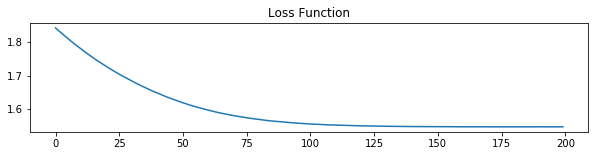

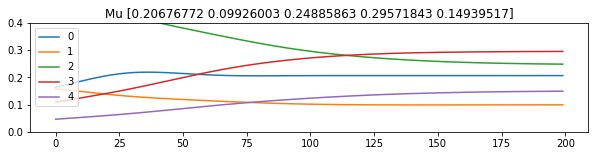

In [20]:
plt.figure(figsize=[10, 2])
plt.title('Loss Function')
plt.plot(loss_list)
#plt.ylim([0.5, 2])
plt.show()

plt.figure(figsize=[10, 2])
plt.title('Mu ' + str(mu_list[-1]))
for k in range(K):
    plt.plot(mu_list[:, k], label=str(k))
plt.ylim([0, 0.4])
plt.legend()
plt.show()